Starting with the prediction  
1)already downloaded the data needed  
2)we try to take every asspect into consideration but this is the first time
#first we need to divide the training set into two parts ,we have arround 1400,so let us divide 3 : 1
#but before that let us handle missing values

In [433]:
import numpy as np
import pandas as pd
import os

datapath = "house-prices-advanced-regression-techniques"
trainfile = "train.csv"

source = pd.read_csv(os.path.join(datapath,trainfile))

Look for missing values

In [434]:
coloums_to_skip = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','MasVnrType']
copy_data = source.drop(columns=coloums_to_skip)
print("coloums : ",copy_data.columns.shape)
count_of_rows_with_missing_values = copy_data.isnull().any(axis=1).sum()
print('number of rows : ',count_of_rows_with_missing_values)
print(copy_data[copy_data.isnull().any(axis=1)].loc[:,copy_data.isnull().any()])
print(copy_data[copy_data.isnull()['LotFrontage'] == 1].loc[:,'LotFrontage'])
print(copy_data[copy_data.isnull()['MasVnrArea'] == 1].loc[:,'MasVnrArea'])
print(copy_data[copy_data.isnull()['Electrical'] == 1].loc[:,'Electrical'])
print(copy_data[copy_data.isnull()['GarageYrBlt'] == 1].loc[:,'GarageYrBlt'])


coloums :  (66,)
number of rows :  340
      LotFrontage  MasVnrArea Electrical  GarageYrBlt
7             NaN       240.0      SBrkr       1973.0
12            NaN         0.0      SBrkr       1962.0
14            NaN       212.0      SBrkr       1960.0
16            NaN       180.0      SBrkr       1970.0
24            NaN         0.0      SBrkr       1968.0
...           ...         ...        ...          ...
1443          NaN         0.0      FuseF       1916.0
1446          NaN       189.0      SBrkr       1962.0
1449         21.0         0.0      SBrkr          NaN
1450         60.0         0.0      SBrkr          NaN
1453         90.0         0.0      SBrkr          NaN

[340 rows x 4 columns]
7      NaN
12     NaN
14     NaN
16     NaN
24     NaN
        ..
1429   NaN
1431   NaN
1441   NaN
1443   NaN
1446   NaN
Name: LotFrontage, Length: 259, dtype: float64
234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64


So we decided to fill the missing values with mean
But before that we dont want to fill the coloumns to skip with mean because the have some meaning,so before doing that we want to replace the Nan with a string maybe "miss" 

In [435]:
data = source
for i in coloums_to_skip :
    data[i].fillna("miss")

so we now divide the data into 3 : 1 set , one to test and other to train

In [436]:
np.random.seed(0)
train_mask = np.random.rand(len(data)) < 0.75
train_set = data[train_mask]
test_set = data[~train_mask]

print("Train Set Description:")
print(train_set.describe())

print("\nTest Set Description:")
print(test_set.describe())

Train Set Description:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1087.000000  1087.000000   895.000000    1087.000000  1087.000000   
mean    716.992640    56.062557    69.948603   10395.214351     6.095676   
std     420.738875    41.652643    23.980595    9692.363876     1.400490   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     351.500000    20.000000    59.500000    7614.500000     5.000000   
50%     706.000000    50.000000    69.000000    9477.000000     6.000000   
75%    1072.000000    70.000000    80.000000   11500.000000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1087.000000  1087.000000   1087.000000  1080.000000  1087.000000  ...   
mean      5.589696  1971.021159   1985.289788    98.437963   428.527139  ...   
std       1.146299    30.635331     20.674530   167.

Now on we will only deal with train set

In [437]:
train_dummy = pd.get_dummies(train_set)
def fillna(train_dummy) : 
    coloums = train_dummy.columns
    for i in coloums :
        mean = train_dummy[i].mean()
        train_dummy[i] = train_dummy[i].fillna(mean)
    return 
fillna(train_dummy)


I have seen a high instability in r^2 which might be due to the multi collinearity ,so we would like to elimate one of the two with high co-relation

In [438]:

def remove_highly_correlated_features(D, threshold=0.9):
    """
    Removes highly correlated features from the DataFrame.
    
    Parameters:
    D : pd.DataFrame : The input DataFrame with features.
    threshold : float : The correlation threshold above which features are considered highly correlated (default is 0.9).
    
    Returns:
    pd.DataFrame : The cleaned DataFrame with highly correlated features removed.
    """
    # Step 1: Calculate the correlation matrix
    corr_matrix = D.corr()

    # Step 2: Find pairs of features with high correlation
    drop_columns = []

    for column in corr_matrix.columns:
        # Look at the correlation of this column with all other columns
        highly_corr = corr_matrix[column].abs() > threshold
        # Exclude the diagonal elements (correlation with itself)
        highly_corr = highly_corr[highly_corr].index.tolist()
        for col in highly_corr:
            if col != column:  # Avoid pairing with itself
                drop_columns.append(col)

    # Step 3: Drop the correlated columns
    D_clean = D.drop(columns=set(drop_columns))

    return D_clean

# Example usage:
# cleaned_data = remove_highly_correlated_features(D, threshold=0.9)
# You can then use cleaned_data to train your model


In [439]:
train_dummy = remove_highly_correlated_features(train_dummy)

We are done with the data preprocessing , atleast for the trainging set .  
We go into the model .  
I would like to do the linear regression with alpha and beta as hyperparametes

after running for parameters, I have found that there is a string case of 

In [440]:

def train(D,alpha = 0,beta = 1) :
    #D : Data
    #alpha : hyperparameter for variance of prior of parameters
    #beta : variance of error (Beta*I)
    y = D['SalePrice'].to_numpy()
    y = y.astype(np.float64)
    X = D.to_numpy()
    X = X.astype(np.float64)
    for i in range(len(X[:,-1])) :
        X[i][-1] = 1
    (n,m) = X.shape
    S_inv = alpha * np.eye(m) + beta * np.dot(X.T , X)

    S = np.linalg.inv(S_inv)
    parameters = beta * np.dot(S , np.dot(X.T , y))
    return parameters


Looking at the dataset for RMS(cost fuction) and maybe R^2

In [441]:
X = train_dummy.iloc[:,:-1].to_numpy()
y = train_dummy['SalePrice'].to_numpy()
temp = np.ones((1087,1))
X = np.hstack((X,temp))
parameters = train(train_dummy,0.000001,0.01)

print(parameters)
print(parameters.shape," : shape of parameters")
print("shape of x : ",X.shape)
print("shape of y : ",y.shape)

[-8.46706623e-01 -3.57321732e+01  5.30920967e+01 -6.52569249e-02
 -2.98086639e+02  1.65387112e+02 -1.55658267e+01  1.52643766e+01
  2.93521498e-01  1.60000000e-01  2.40000000e-01  3.20000000e-01
  6.40000000e-01  4.80000000e-01 -2.40000000e-01 -1.60000000e-01
 -6.40000000e-01  1.00727558e-03 -1.43081665e-03  7.04712868e-04
 -1.03788376e-03  8.56928825e-04  8.23135376e-04 -2.72769928e-04
  5.14221191e-05 -9.75459814e-06  6.54745102e-05 -4.73484397e-08
  1.39761250e-07  2.03285366e-06  9.91150737e-07  8.18185508e-07
  4.97214496e-07  1.86964869e-06 -4.09036875e-07 -1.13832951e-05
  1.91955566e-04  1.00000000e+00  1.57109375e-01  1.57343750e-01
  1.57050781e-01  1.56894531e-01  1.56875000e-01  2.61380672e-04
 -1.97643161e-03 -3.20060253e-04  1.53927803e-04  3.39921875e-01
  3.39843750e-01  3.39726562e-01  3.39726562e-01  2.69531250e-01
  2.69550781e-01  2.69453125e-01  2.69726562e-01  2.69628906e-01
  8.69548321e-04 -3.64845459e+00 -3.65777832e+00 -3.64893066e+00
 -3.64786865e+00 -3.64811

In [442]:
print(parameters[-1])
def predict(X,parameters) :
    return np.dot(X,parameters)

0.00453125


In [443]:
def RMS(X,y) :
    t = predict(X,parameters)
    return np.sqrt(np.mean((t-y)**2))

def r_square(X,y) :
    t = predict(X,parameters)
    y_mean = np.mean(y)
    RSS = np.sum((t - y)**2)
    TSS = np.sum((y - y_mean)**2)
    print("RSS : ",RSS)
    print("TSS : ",TSS)
    return 1 - RSS/TSS


Now let us see how our predicitons work(fingers crossed)

In [444]:
print("RMS is : ",RMS(X,y))
print("R^2 : ",r_square(X,y))

RMS is :  2396.187760645576
RSS :  6241245057.498946
TSS :  6879660841736.947
R^2 :  0.999092797566468


In [445]:
test_dummy = pd.get_dummies(test_set)
fillna(test_dummy)
extra_columns = set(test_dummy.columns) - set(train_dummy.columns)
test_dummy = test_dummy.drop(columns=extra_columns)

# Step 2: Add missing columns from train_dummy to test_dummy, initialized to 0
missing_columns = set(train_dummy.columns) - set(test_dummy.columns)
missing_df = pd.DataFrame(0, index=test_dummy.index, columns=list(missing_columns))

# Concatenate the missing columns to test_dummy
test_dummy = pd.concat([test_dummy, missing_df], axis=1)

# Check the updated DataFrame test_dummy
print(test_dummy)

        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
7        8          60    70.346405    10382            7            6   
8        9          50    51.000000     6120            7            5   
10      11          20    70.000000    11200            5            5   
13      14          20    91.000000    10652            7            5   
17      18          90    72.000000    10791            4            5   
...    ...         ...          ...      ...          ...          ...   
1449  1450         180    21.000000     1533            5            7   
1450  1451          90    60.000000     9000            5            5   
1452  1453         180    35.000000     3675            5            5   
1453  1454          20    90.000000    17217            5            5   
1458  1459          20    68.000000     9717            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  MiscFeature_Othr  \
7          1973          1973  

In [446]:
X_test = test_dummy.iloc[:,:-1].to_numpy()
y_test = test_dummy['SalePrice'].to_numpy()
(n,m) = X_test.shape
temp = np.ones((n,1))
X_test = np.hstack((X_test,temp))

In [447]:
alpha = [1000,100,10,1,0,0.1,0.01,0.001,0.0001,0.00001,0.000001]
beta = [1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
r_sq = np.zeros((11,11))
for i in range(len(alpha)) :
    for j in range(len(beta)) :
        parameters = train(train_dummy,alpha[i],beta[j])
        r_sq[i,j] = r_square(X_test,y_test)
parameters = train(train_dummy,0.000001,0.01)
#print(y_test)
#print(predict(X_test,parameters))
#print(r_sq)

RSS :  37.33409357989001
TSS :  2323334747839.067
RSS :  0.3935130466450599
TSS :  2323334747839.067
RSS :  0.0028495622605303225
TSS :  2323334747839.067
RSS :  4.4963521296471304e-05
TSS :  2323334747839.067
RSS :  5.7496250113105824e-05
TSS :  2323334747839.067
RSS :  0.0049118779781979404
TSS :  2323334747839.067
RSS :  0.4260384638602908
TSS :  2323334747839.067
RSS :  35.105680701817356
TSS :  2323334747839.067
RSS :  1699.8496849718042
TSS :  2323334747839.067
RSS :  49967.85119286549
TSS :  2323334747839.067
RSS :  1365.98383828722
TSS :  2323334747839.067
RSS :  10.283180659465916
TSS :  2323334747839.067
RSS :  0.3009686828728816
TSS :  2323334747839.067
RSS :  0.001278767988557554
TSS :  2323334747839.067
RSS :  1.3431755619964925e-05
TSS :  2323334747839.067
RSS :  5.7358051109555785e-05
TSS :  2323334747839.067
RSS :  0.0049117544546844975
TSS :  2323334747839.067
RSS :  0.42603709076252566
TSS :  2323334747839.067
RSS :  35.10567928872501
TSS :  2323334747839.067
RSS :  1

I think we are ready for the final submitions  
We read the data  
preprocess it  
predicit it  
and write it to a csv  

In [448]:
testing_source = pd.read_csv(os.path.join(datapath,'test.csv'))

In [449]:
test_data = testing_source
for i in coloums_to_skip :
    test_data[i].fillna('miss')
test_dummy = pd.get_dummies(test_data)
fillna(test_dummy)
extra_columns = set(test_dummy.columns) - set(train_dummy.columns)
test_dummy = test_dummy.drop(columns=extra_columns)

# Step 2: Add missing columns from train_dummy to test_dummy, initialized to 0
missing_columns = set(train_dummy.columns) - set(test_dummy.columns)
missing_df = pd.DataFrame(0, index=test_dummy.index, columns=list(missing_columns))

# Concatenate the missing columns to test_dummy
test_dummy = pd.concat([test_dummy, missing_df], axis=1)

# Check the updated DataFrame test_dummy
print(test_dummy)
X_test = test_dummy.iloc[:,:-1].to_numpy()
y_test = test_dummy['SalePrice'].to_numpy()
(n,m) = X_test.shape
temp = np.ones((n,1))
X_test = np.hstack((X_test,temp))


        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0     1461          20         80.0    11622            5            6   
1     1462          20         81.0    14267            6            6   
2     1463          60         74.0    13830            5            5   
3     1464          60         78.0     9978            6            6   
4     1465         120         43.0     5005            8            5   
...    ...         ...          ...      ...          ...          ...   
1454  2915         160         21.0     1936            4            7   
1455  2916         160         21.0     1894            4            5   
1456  2917          20        160.0    20000            5            7   
1457  2918          85         62.0    10441            5            5   
1458  2919          60         74.0     9627            7            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  Condition2_RRAn  \
0          1961          1961   

In [450]:
final_predictions = predict(test_dummy.to_numpy(),parameters)

In [451]:
final_results = pd.DataFrame({
    'Id' : testing_source['Id'],
    'SalePrice' : final_predictions
})
prediction = 'predictions.csv'
final_results.to_csv(prediction,index=0)

In [452]:
def co_relation(i, j,variables,data_dummy):
    (n, m) = data.shape
    x = variables[i]
    y = variables[j]
    
    sum_x = 0
    sum_y = 0
    count = 0
    
    # Iterate over all rows and check for NaN values
    for p in range(n):
        if pd.notna(data_dummy.loc[p, x]) and pd.notna(data_dummy.loc[p, y]):
            sum_x += data_dummy.loc[p, x]
            sum_y += data_dummy.loc[p, y]
            count += 1
    
    # Calculate means
    x_mean = sum_x / count
    y_mean = sum_y / count
    
    num = 0
    denom1 = 0
    denom2 = 0
    
    # Iterate again to calculate correlation components
    for p in range(n):
        if pd.notna(data_dummy.loc[p, x]) and pd.notna(data_dummy.loc[p, y]):
            num += (data_dummy.loc[p, x] - x_mean) * (data_dummy.loc[p, y] - y_mean)
            denom1 += (data_dummy.loc[p, x] - x_mean)**2
            denom2 += (data_dummy.loc[p, y] - y_mean)**2
    
    # Final correlation calculation
    co_reltn = num / np.sqrt(denom1 * denom2)
    return co_reltn

#can use corr function to find the correlation
#print(co_relation(0,1))
#print(data_dummy[variables[0]].corr(data_dummy[variables[1]]))

Now we want to visualize the co-relation between pairs

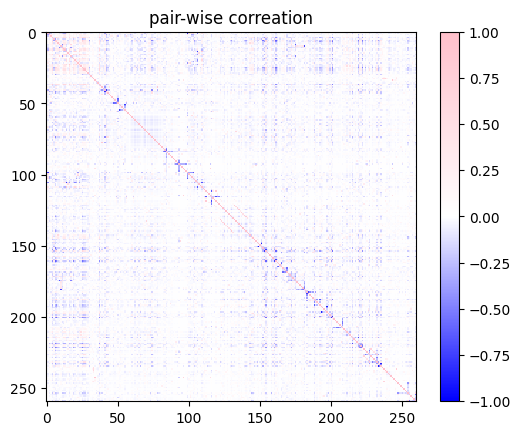

In [453]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#(n,m) = data_dummy.shape
m = 20
"""
intencity = np.zeros((m,m))
for i in range(m) :
    for j in range(m) :
        intencity[i][j] = data_dummy[variables[i]].corr(data_dummy[variables[j]],method="pearson")
"""
#correlation of the complete matrix can be done using .corr on th matrix
intencity = train_dummy.corr()
colors = ['blue', 'white', 'pink']  # Color transition: from blue for -1 to white, then pink for +1
ncolors = 256  # Number of discrete colors in the colormap
cmap = LinearSegmentedColormap.from_list("pink_white_inverse", colors, N=ncolors)
plt.imshow(intencity,cmap=cmap,interpolation='nearest',vmin=-1,vmax=1)
plt.colorbar()
plt.title("pair-wise correation")
plt.show()

!! I have obseved that the dummy variables like (say) gender ,were divided into gender_male , gender_female which are two variables thar are perfectly collinear ,but we dont want that collinearity in our variables so what could be a alternative ??  
Let us first look at the variables with high co-relation

Now lets try looking at the kind of relation between each of these pairs